In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

In [2]:
path = '/Users/jonkqiku/ECHA/FUT'

In [3]:
symb = 'ADAUSDT'

In [4]:
files = sorted([f for f in os.listdir(os.path.join(path, 'Trades')) if f.split('_')[0] == 'ADAUSDT'])

In [5]:
trades = np.empty((0,6))
for f in files:
    x = np.load(os.path.join(path, 'Trades', f))
    trades = np.vstack((trades, x))

In [6]:
ids = trades[:,0].astype(int)
d = np.diff(ids)
b = np.where(d > 1)[0][0]
trades = trades[:b+1]
ids = trades[:,0].astype(int)

In [7]:
len(str(int(trades[0,4])))

13

In [8]:
t0 = int(trades[0,4])
t1 = int(trades[-1,4])

In [9]:
files = sorted([f for f in os.listdir(os.path.join(path, 'OIS')) if f.split('_')[0] == 'ADAUSDT'])

In [10]:
files_t = [int(f.split('_')[1][:-4]) for f in files]

In [11]:
a = 0
while files_t[a] < t0:
    a += 1
a = a - 1

In [12]:
b = 0
while files_t[b] < t1:
    b += 1

In [13]:
files = files[a:b+1]

In [14]:
ois = np.empty((0,4))
for f in files:
    x = np.load(os.path.join(path, 'OIS', f))
    ois = np.vstack((ois, x))

In [15]:
us = np.unique(ids)

In [16]:
unidx = [np.where(ids == u)[0][0] for u in us]

In [17]:
trades = trades[unidx]

In [18]:
ids = ids[unidx]

In [19]:
all(i <= j for i,j in zip(trades[:,4], trades[1:,4]))

True

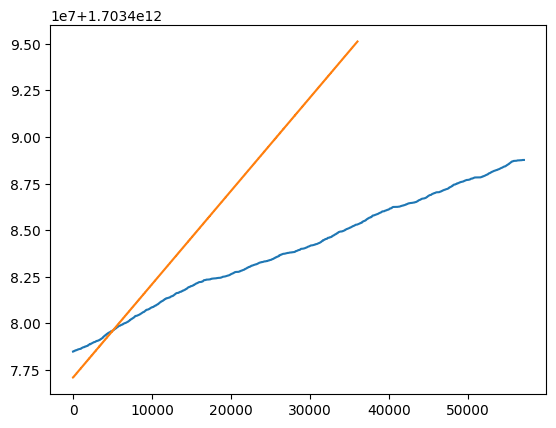

In [20]:
plt.plot(trades[:,4])
plt.plot(ois[:,0])

In [21]:
t0 = int(trades[0,4])
t1 = int(trades[-1,4])

In [22]:
a = 0
while ois[a,0] < t0:
    a += 1
a = a - 1

In [23]:
b = 0
while ois[b,0] < t1:
    b += 1

In [24]:
ois = ois[a:b+1]

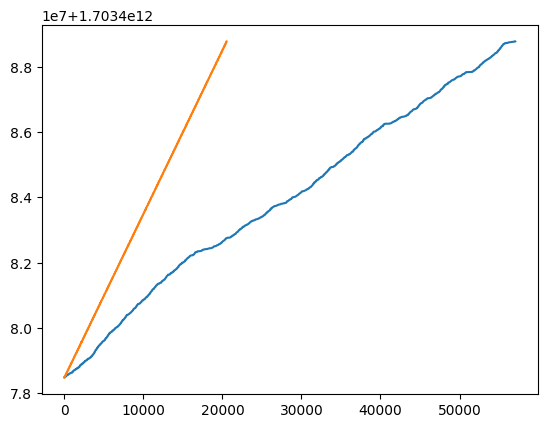

In [25]:
plt.plot(trades[:,4])
plt.plot(ois[:,0]);

In [26]:
ois[0,0] < trades[0,4]

True

In [27]:
ois[-1,0] > trades[-1,4]

True

In [28]:
us = np.unique(ois[:,0])

In [29]:
unidx = [np.where(ois[:,0] == u)[0][0] for u in us]

In [30]:
ois = ois[unidx]

In [31]:
times_t = trades[:,4]
times_o = ois[:,0]

In [32]:
intervals_o = [(times_o[i-1], times_o[i]) for i in range(1,len(times_o))]

In [33]:
trades_idxs = []
i = 0
for it in intervals_o:
    idxs = []
    while i < len(times_t) and times_t[i] > it[0] and times_t[i] <= it[1]:
        idxs.append(i)
        i += 1
    trades_idxs.append(idxs) 

In [34]:
inter_lens = np.array([len(idxs) for idxs in trades_idxs])

In [35]:
np.where(inter_lens > 15)[0]

array([   0,    4,    6, ..., 2788, 2789, 2790])

In [36]:
tra = trades[trades_idxs[0]]

In [37]:
ps = tra[:,1]

In [38]:
qs = tra[:,2]

In [39]:
ts = tra[:,4]

In [40]:
np.unique(ps)

array([0.6064, 0.6065, 0.6066])

In [41]:
dois = np.diff(ois[:,1])

In [42]:
combinations = {}
path = '/Users/jonkqiku/Documents/Projects/Combinations/int'
for i in range(1,16):
    name = 'cwr_' + str(i) + '.npy'
    combinations[i] = np.load(os.path.join(path, name))

In [43]:
small_idxs = np.where(inter_lens <= 15)[0]

In [44]:
match_combi = {}
mins = []
for i in tqdm(small_idxs):
    doi = dois[i]
    tra = trades[trades_idxs[i]]
    qs = tra[:,2]
    if len(qs) > 0:
        v = np.matmul(combinations[len(qs)], qs)
        d = abs(v - doi)
        j = np.where(d == min(d))[0]
        match_combi[i] = combinations[len(qs)][j]

  0%|          | 0/1570 [00:00<?, ?it/s]

100%|██████████| 1570/1570 [01:26<00:00, 18.24it/s]


In [45]:
mins = np.empty(len(match_combi))
frac = np.empty(len(match_combi))
match_mins = {}
for i,j in enumerate(match_combi.keys()):
    v = match_combi[j][0].dot(trades[trades_idxs[j]][:,2])
    mins[i] = abs(dois[j] - v)
    match_mins[j] = abs(dois[j] - v)
    if dois[j] > 0:
        frac[i] = abs(dois[j]-v)/abs(dois[j])
    else:
        frac[i] = 0

In [46]:
n_combi = np.array([len(match_combi[k]) for k in match_combi.keys()])

In [47]:
match_lens = {k: len(match_combi[k]) for k in match_combi.keys()}

In [48]:
(inter_lens <= 15).mean() * (n_combi == 1).mean() * (mins == 0).mean()

0.270586737223745

In [49]:
a = np.array(list(match_lens.values())) == 1
b = np.array(list(match_mins.values())) == 0
c = np.array([i and j for i,j in zip(a,b)])

In [50]:
rec_trades = np.empty((0,8))
for i in match_combi.keys():
    if match_lens[i] == 1 and match_mins[i] == 0:
        idxs = np.array(trades_idxs[i]).reshape(-1,1)
        I = match_combi[i].reshape(-1,1)
        tras = trades[trades_idxs[i]]
        rec = np.hstack((tras, idxs, I))
        rec_trades = np.vstack((rec_trades, rec))

In [51]:
len(rec_trades) / len(trades)

0.0405012267788293

In [52]:
rec_trades

array([[ 1.01989663e+09,  6.06400000e-01,  2.06000000e+02, ...,
         0.00000000e+00,  4.60000000e+01, -1.00000000e+00],
       [ 1.01989663e+09,  6.06400000e-01,  9.00000000e+00, ...,
         0.00000000e+00,  4.70000000e+01, -1.00000000e+00],
       [ 1.01989670e+09,  6.06300000e-01,  7.44000000e+02, ...,
         0.00000000e+00,  1.14000000e+02,  1.00000000e+00],
       ...,
       [ 1.01995228e+09,  6.04300000e-01,  3.30000000e+02, ...,
         0.00000000e+00,  5.57010000e+04,  1.00000000e+00],
       [ 1.01995229e+09,  6.04300000e-01,  1.90000000e+01, ...,
         0.00000000e+00,  5.57020000e+04,  1.00000000e+00],
       [ 1.01995229e+09,  6.04200000e-01,  4.20000000e+01, ...,
         1.00000000e+00,  5.57030000e+04,  1.00000000e+00]])

In [63]:
dois

array([ 41875.,   -215.,   2503., ..., -25223., -20615., 105895.])

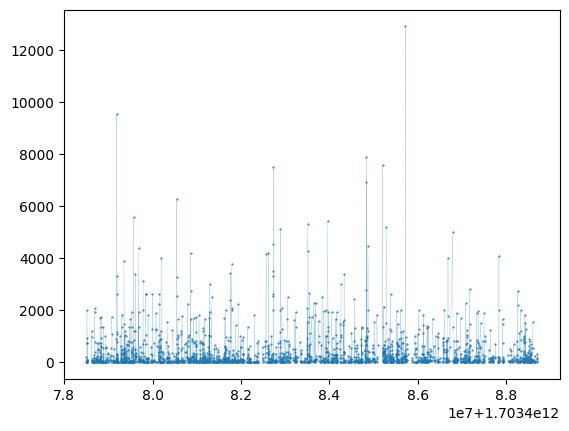

In [66]:
plt.plot(rec_trades[:,4], rec_trades[:,2], lw=.1, marker='.', markersize=1)